# PCB DEFECTS DETECTION
Dataset Used: PCB_augmented

Algorithm applied: Autoencoder

Datapaths

In [2]:
# Setting Folders
input_folder_path = r'R:\SIEMENS_Intern\PCB_augmented'
output_folder_path = r'R:\SIEMENS_Intern\PCB_augmented'  # Make sure this directory exists


Data Preprocessing

In [3]:
import os
import cv2

import numpy as np

def load_processed_images(folder_path, image_size=(100, 100)):
   
    images = []  # Initialize an empty list to store the processed images

    # Iterate over all files found in the specified folder path
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)  # Create the full image path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale mode
        
        if img is not None:  # Check if the image was successfully read
            img = cv2.resize(img, image_size)  # Resize the image to the specified size
            images.append(img)  # Add the processed image to the list

    # Convert the list of images to a numpy array and return it
    # This is useful for further processing or analysis, especially in machine learning tasks
    return np.array(images)

processed_images = load_processed_images(output_folder_path)


Autoencoder model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler

def build_autoencoder(input_shape):

    model = Sequential([
        # Encoder Part
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        
        # Decoder Part
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        UpSampling2D((2, 2)),
        Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')
    ])
    return model

# Example of specifying the input shape for grayscale images of size 100x100
model = build_autoencoder(input_shape=(100, 100, 1))

def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.95  # Reduce the learning rate by 5% after 10 epochs
    return lr  # Keep the learning rate unchanged for the first 10 epochs

# Define callbacks for dynamic adjustments during training
callbacks = [
    LearningRateScheduler(lr_schedule, verbose=1)
]

# Configure the optimizer with an initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model with the specified optimizer and loss function
model.compile(optimizer=optimizer, loss='binary_crossentropy')

Train-test-split

In [5]:
from sklearn.model_selection import train_test_split

# Split the processed images into training, validation, and test sets
# Here, 60% of the data is used for training, and 40% is split evenly between validation and testing.
X_train, X_temp = train_test_split(processed_images, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)  # Splits the remaining data evenly

# Normalize the images to have values between 0 and 1
# This normalization helps with the convergence of the training process
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Reshape for the CNN if necessary (e.g., add channel dimension)
# CNNs require a specific input shape, so we add an additional dimension to represent the color channels
# This is important for grayscale images which might not have a channel dimension
X_train = np.expand_dims(X_train, axis=-1)  # Adds a channel dimension at the end for the training set
X_val = np.expand_dims(X_val, axis=-1)    # Adds a channel dimension at the end for the validation set
X_test = np.expand_dims(X_test, axis=-1)   # Adds a channel dimension at the end for the test set

Model Training

In [6]:
history = model.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_val, X_val), callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
2/2 [==============================] - 10s 2s/step - loss: 0.6936 - val_loss: 0.6924 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
2/2 [==============================] - 8s 2s/step - loss: 0.6925 - val_loss: 0.6909 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
2/2 [==============================] - 8s 2s/step - loss: 0.6909 - val_loss: 0.6878 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
2/2 [==============================] - 8s 2s/step - loss: 0.6879 - val_loss: 0.6832 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/50
2/2 [==============================] - 8s 2s/step - loss: 0.6834 - val_loss: 0.6761 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.

Model Evaluation

In [7]:
# Example of calculating reconstruction error on new data (e.g., X_test)
reconstructed = model.predict(X_test)
errors = np.mean(np.abs(X_test - reconstructed), axis=(1,2,3))
threshold = np.mean(errors) + np.std(errors)  # Simple thresholding strategy
anomalies = errors > threshold


4/4 [==============================] - 1s 127ms/step


In [8]:
anomalies 

array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [9]:
def load_corresponding_original_images(processed_images_folder, original_images_folder, target_size=(100, 100)):
    original_images = []
    for filename in os.listdir(processed_images_folder):
        original_image_path = os.path.join(original_images_folder, filename)
        original_img = cv2.imread(original_image_path)
        if original_img is not None:
            # Resize the image to ensure uniformity
            original_img_resized = cv2.resize(original_img, target_size)
            # Convert BGR to RGB for display purposes
            original_img_rgb = cv2.cvtColor(original_img_resized, cv2.COLOR_BGR2RGB)
            original_images.append(original_img_rgb)
    return np.array(original_images)


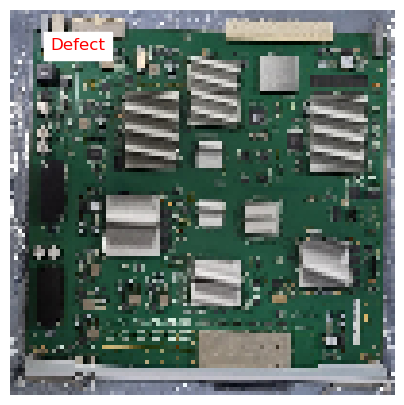

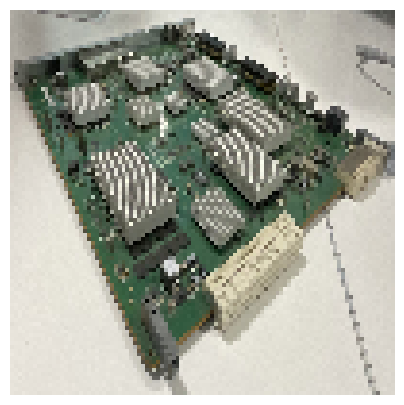

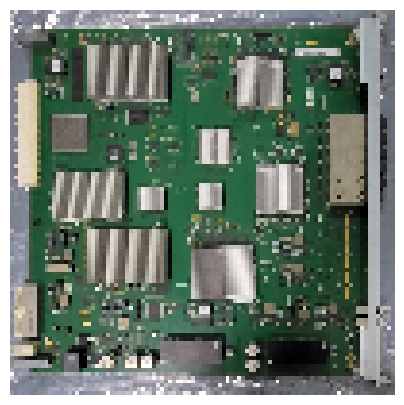

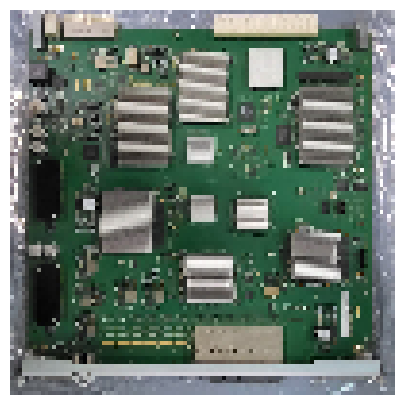

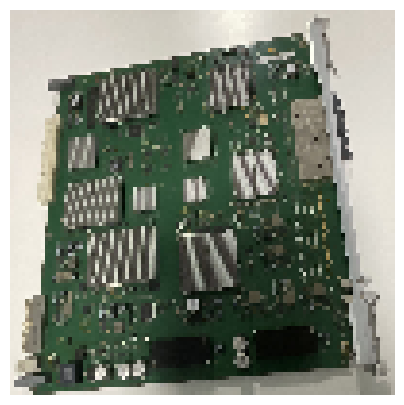

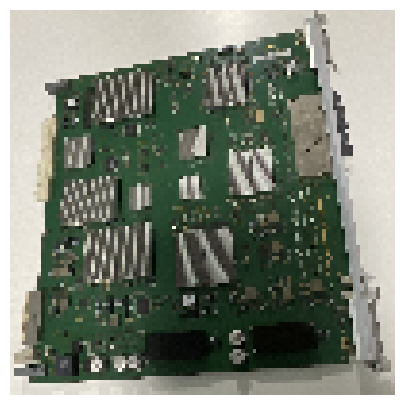

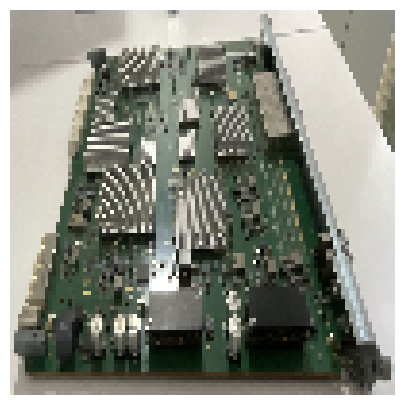

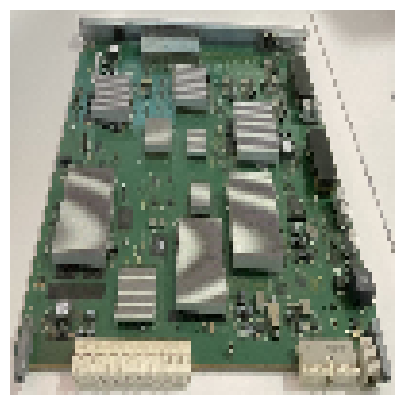

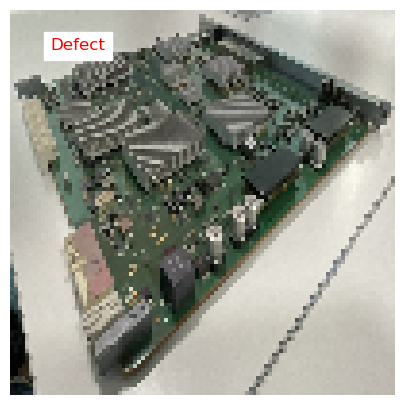

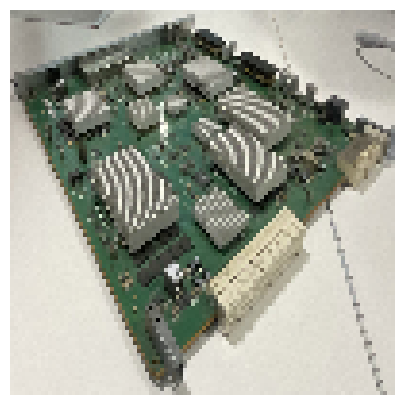

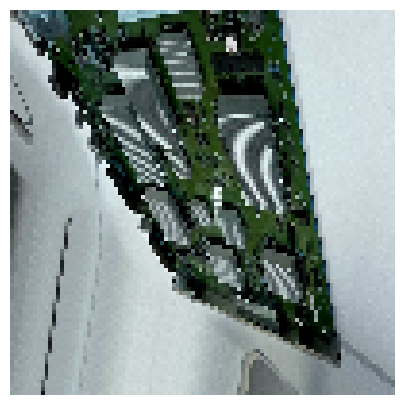

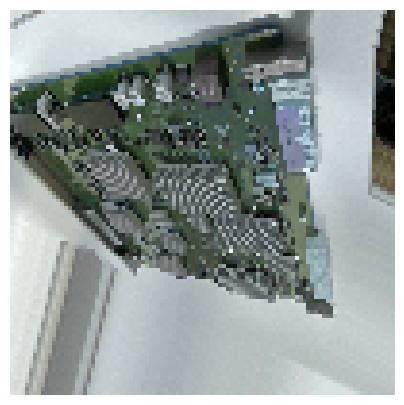

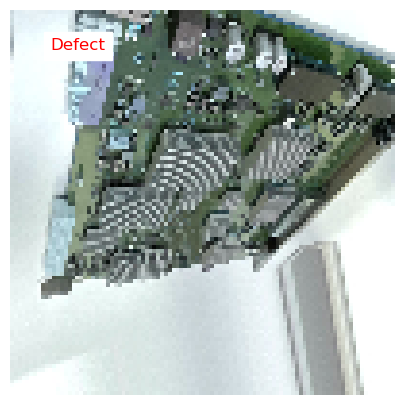

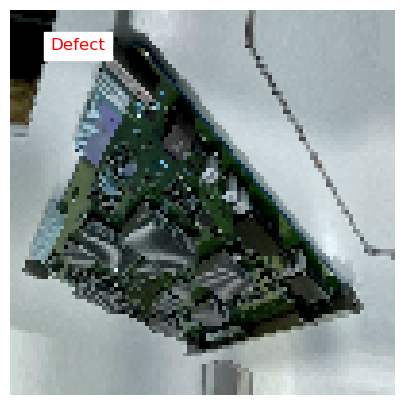

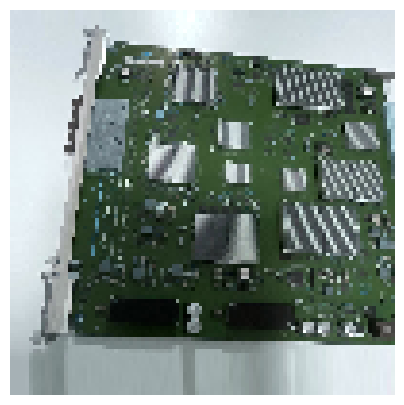

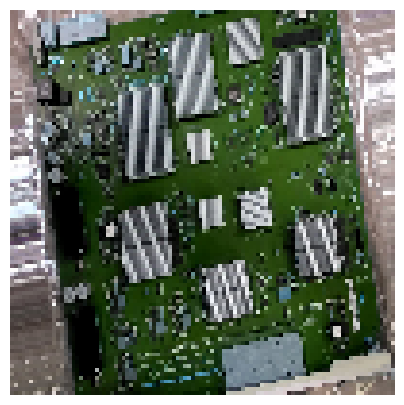

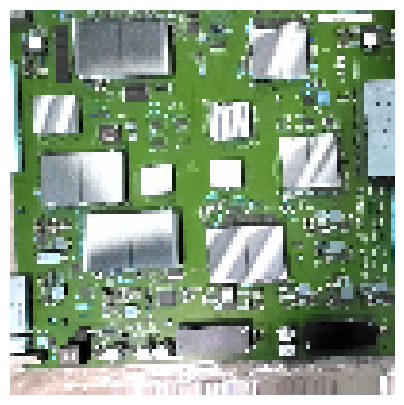

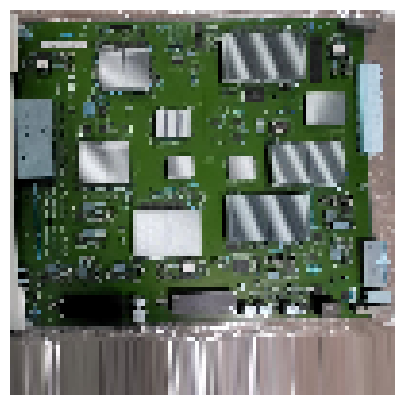

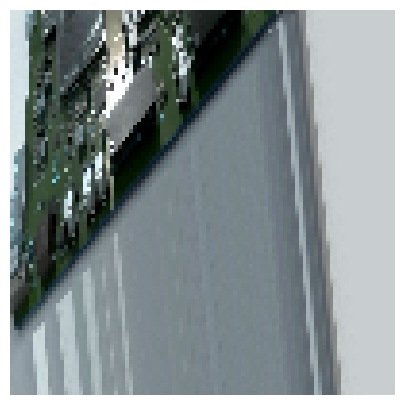

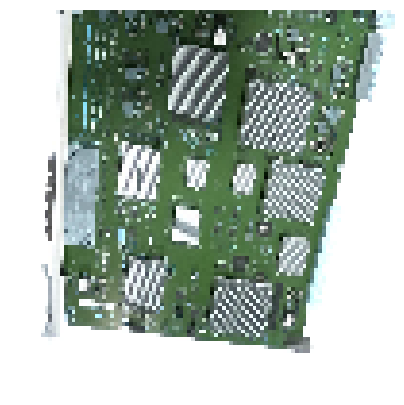

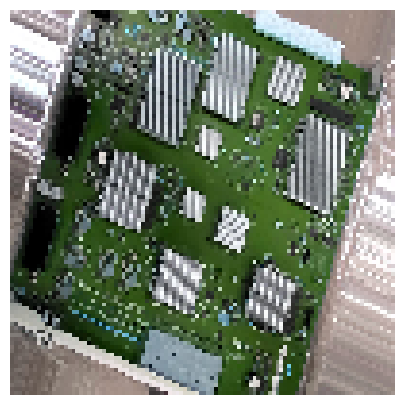

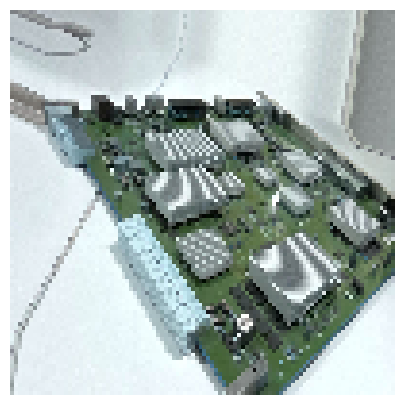

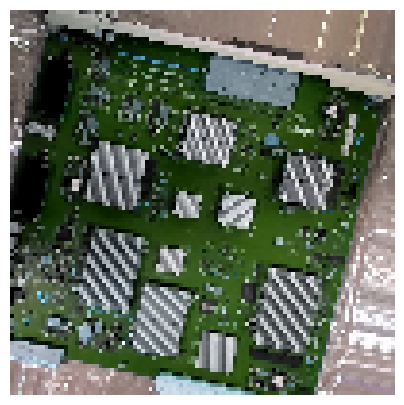

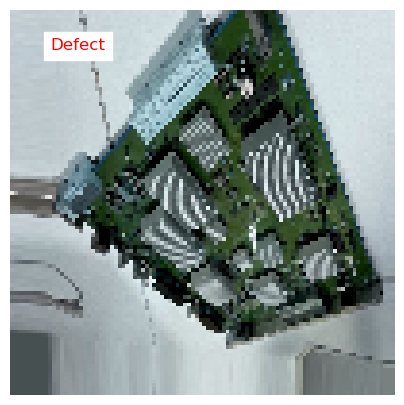

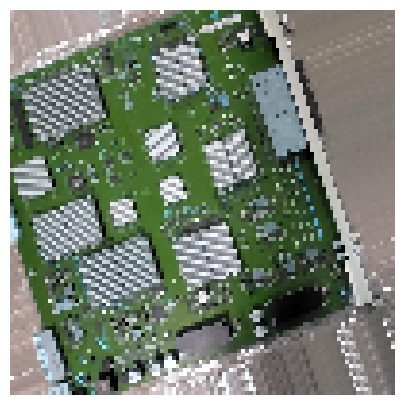

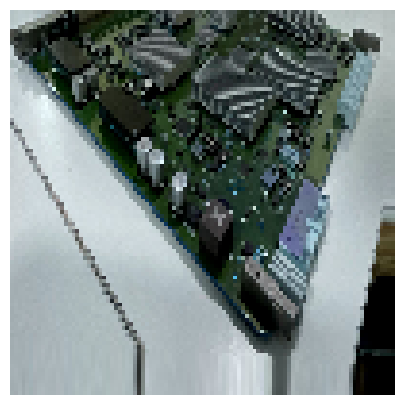

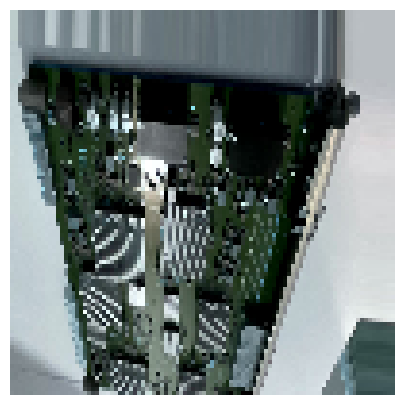

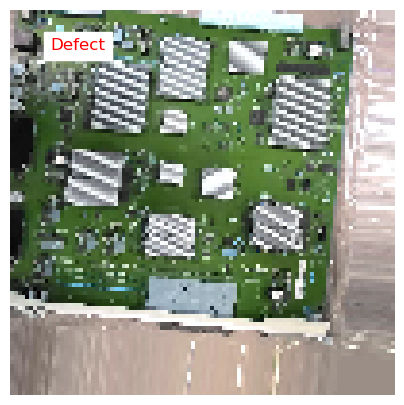

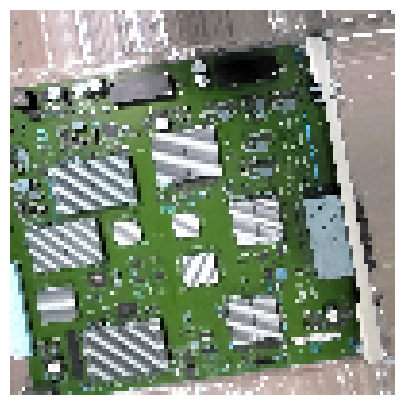

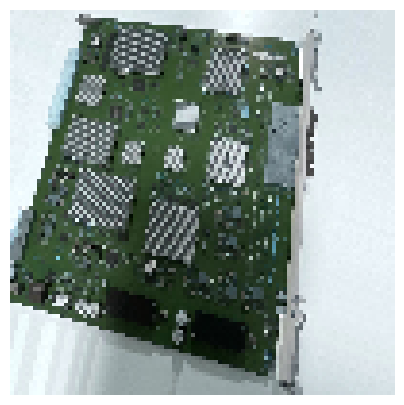

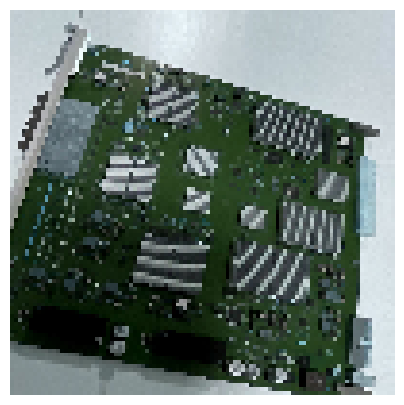

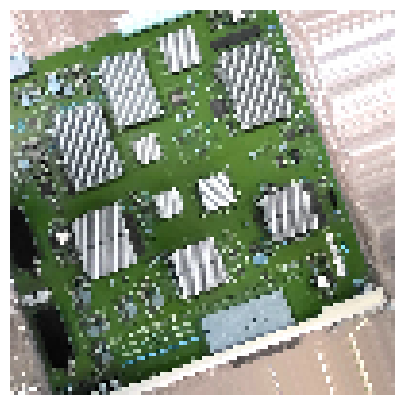

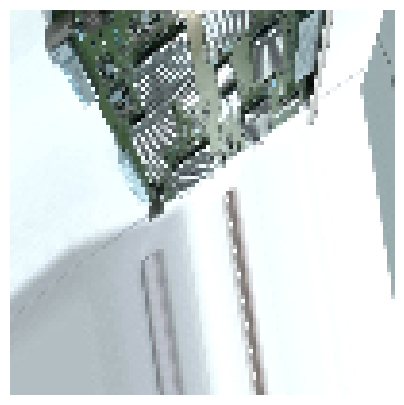

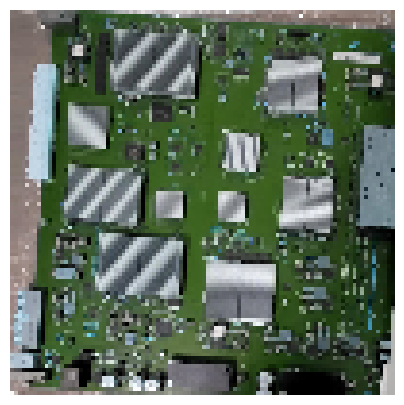

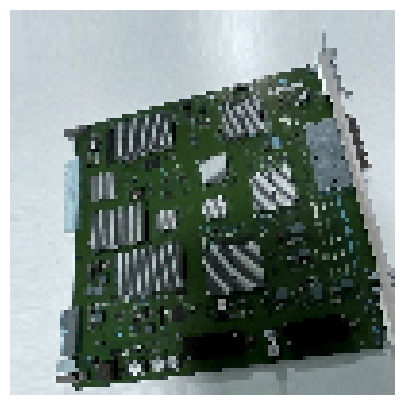

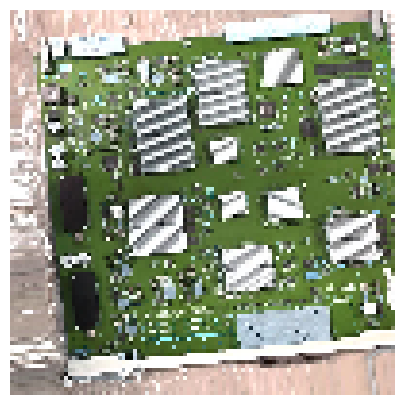

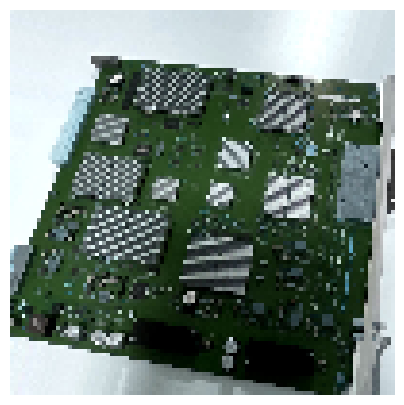

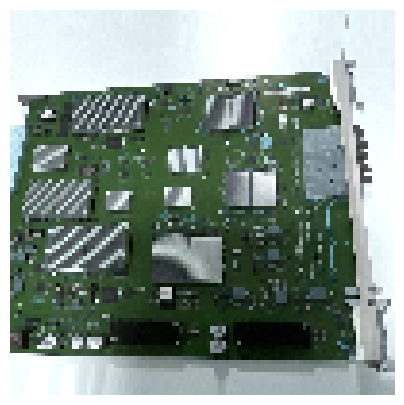

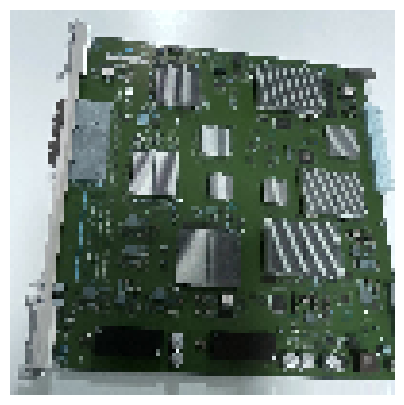

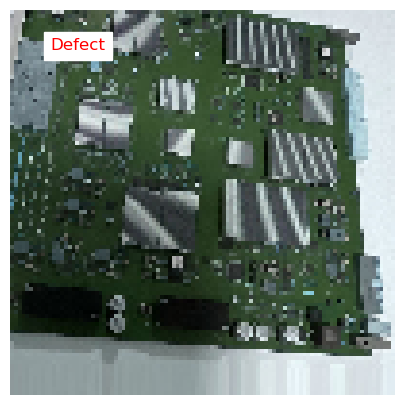

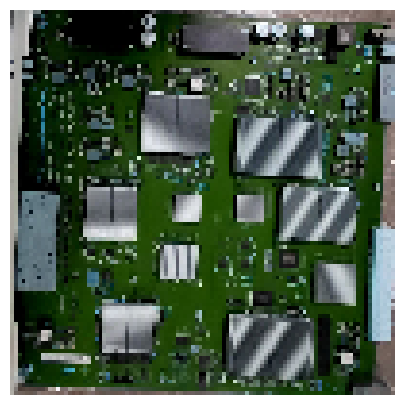

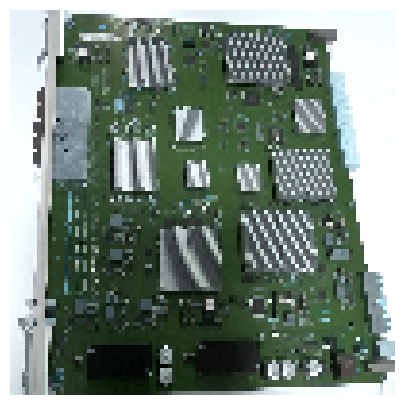

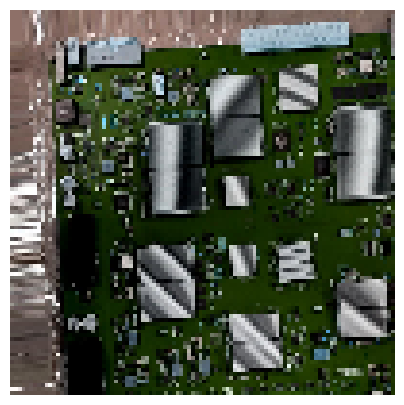

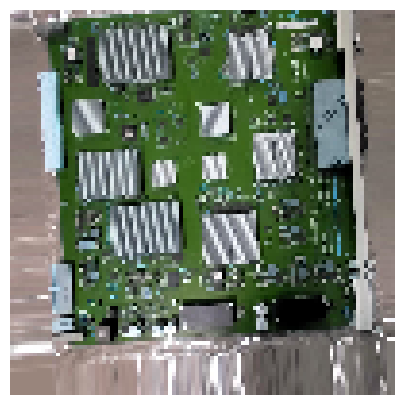

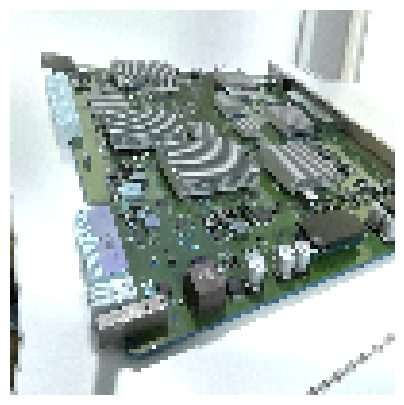

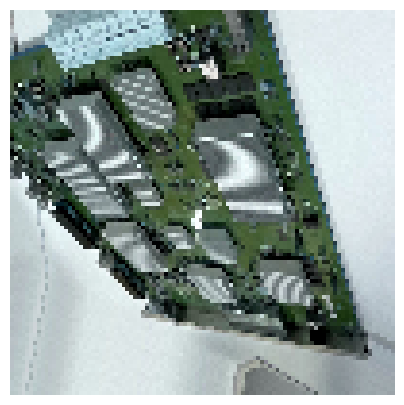

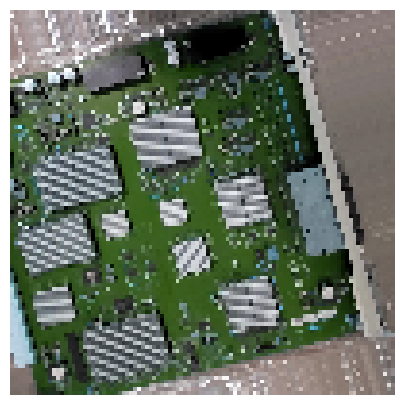

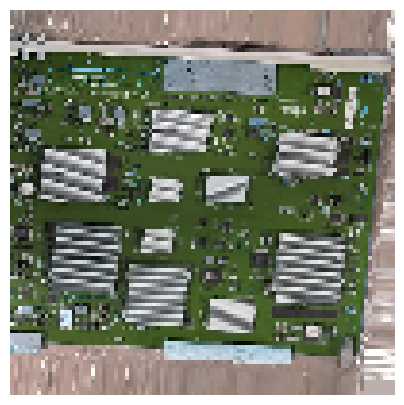

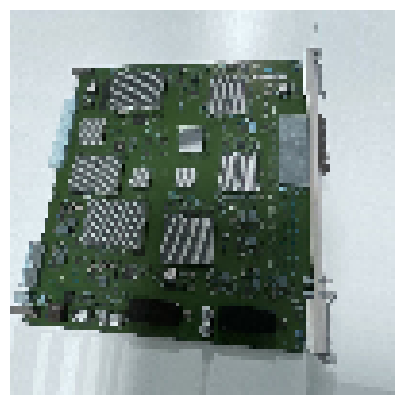

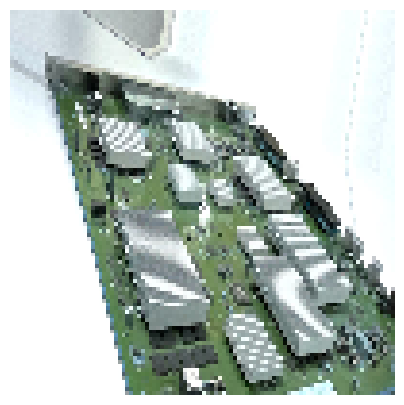

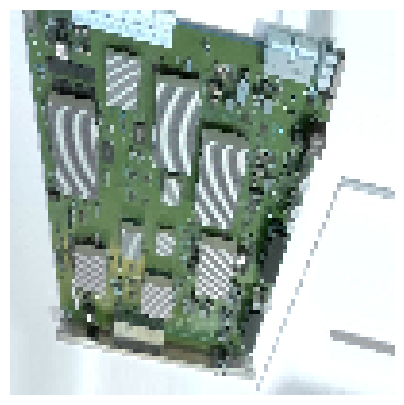

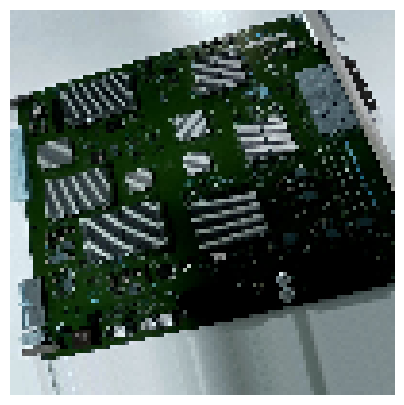

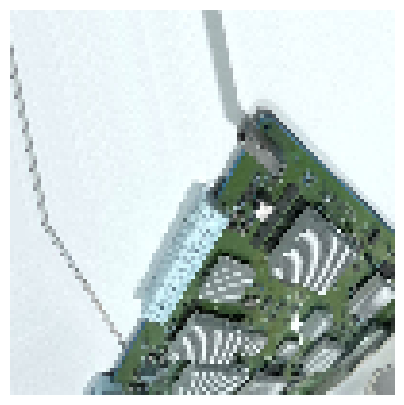

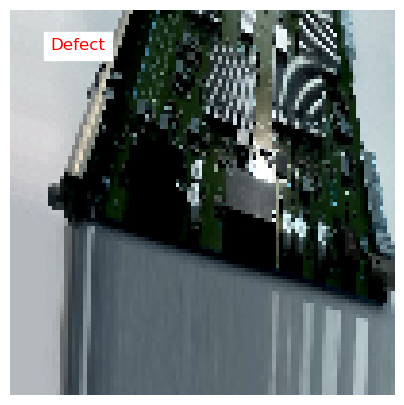

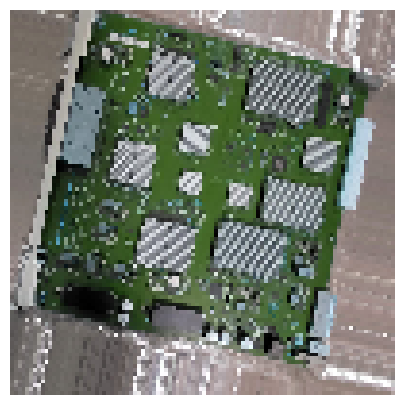

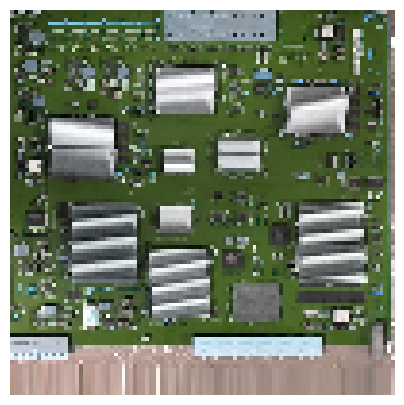

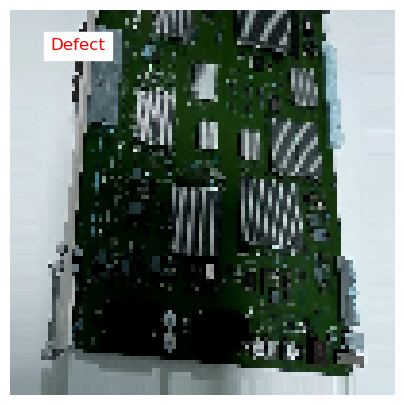

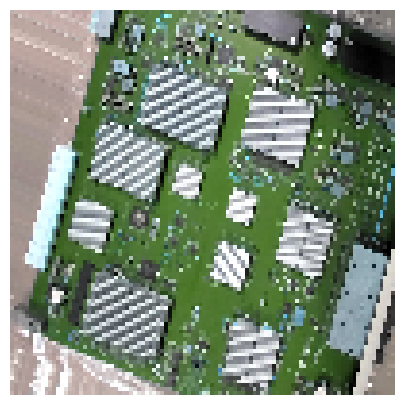

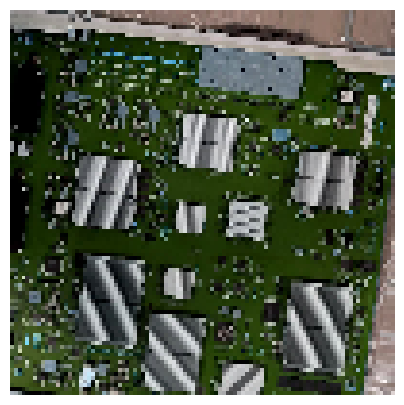

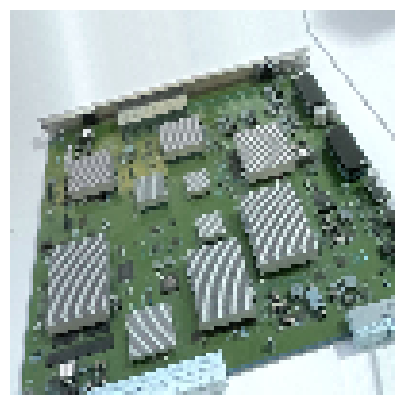

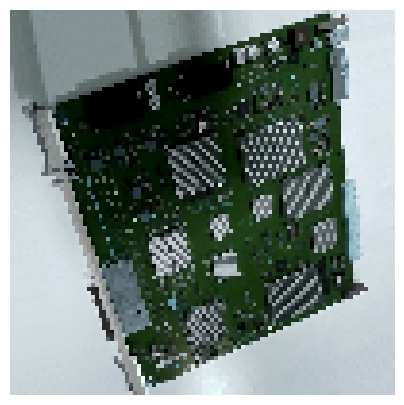

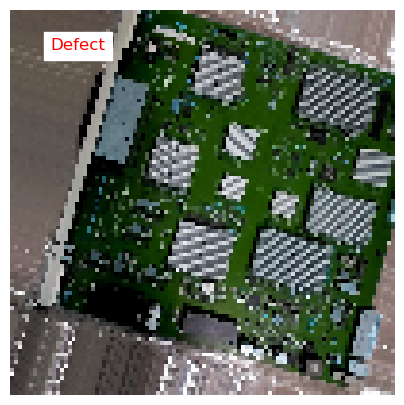

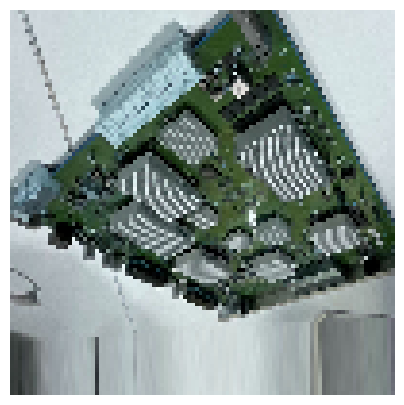

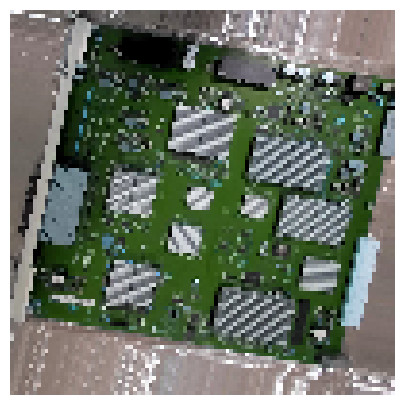

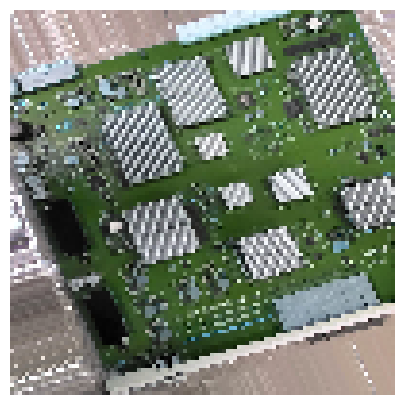

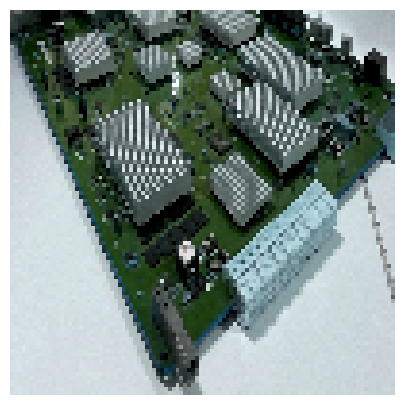

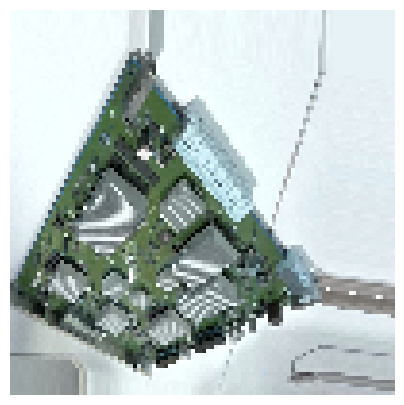

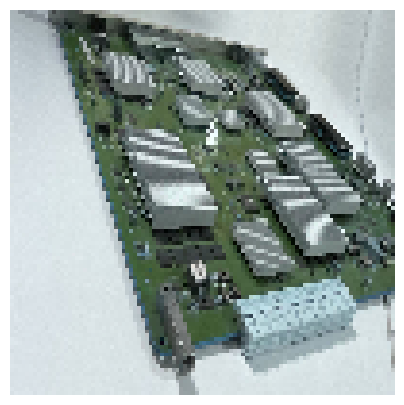

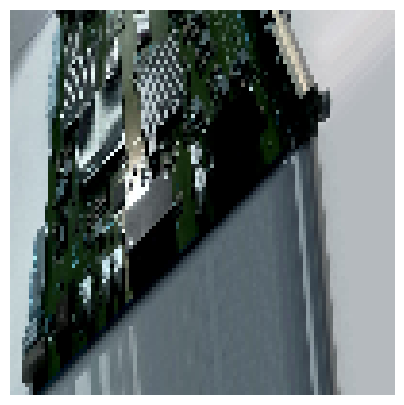

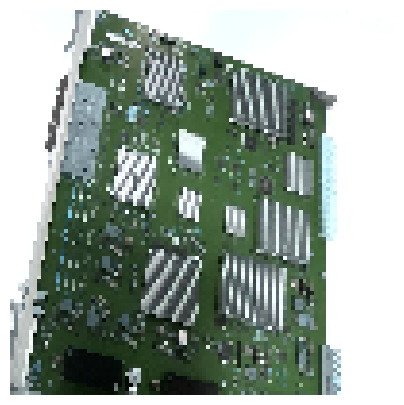

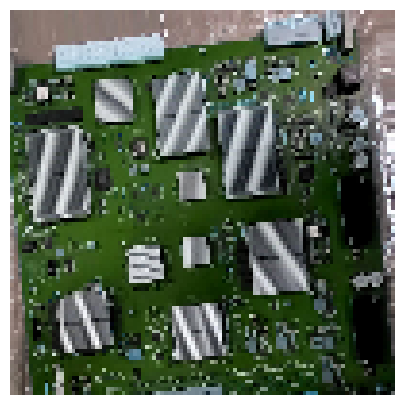

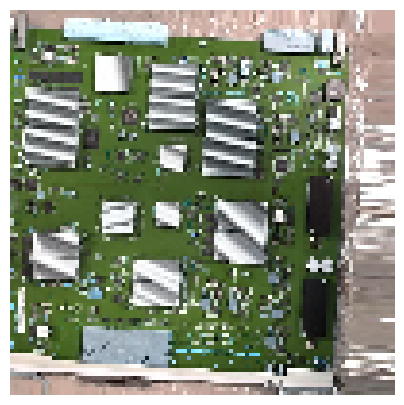

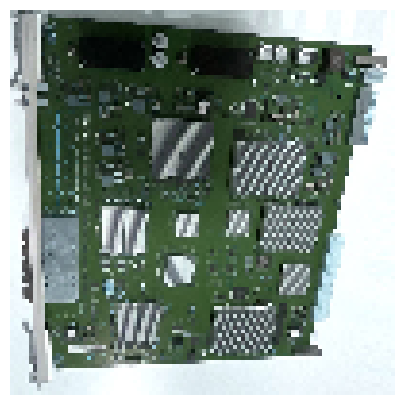

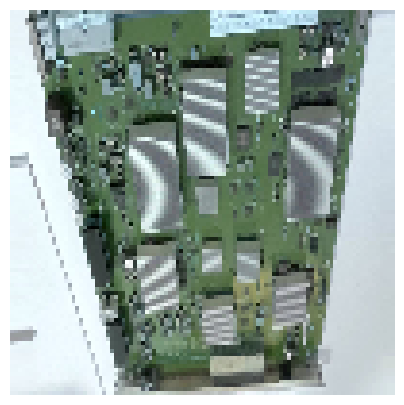

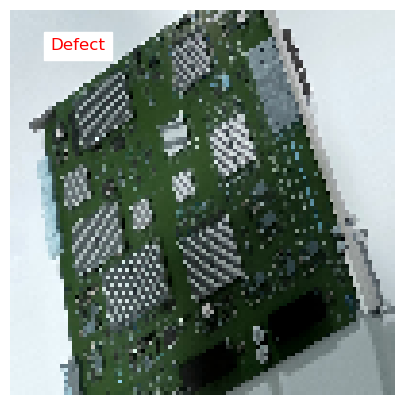

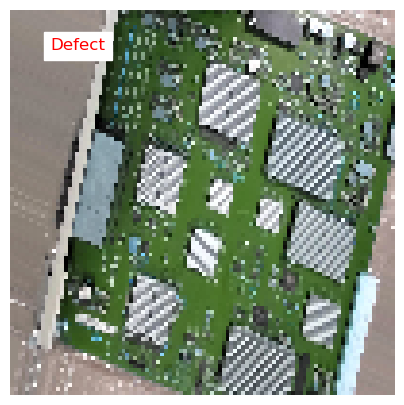

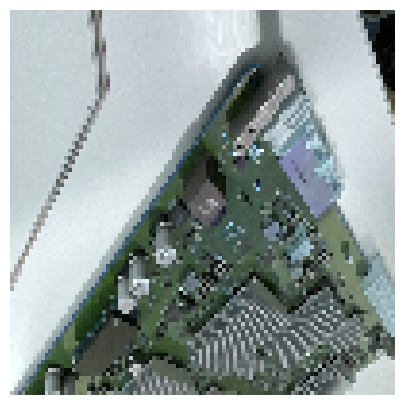

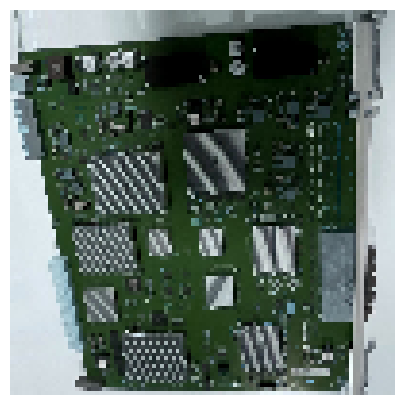

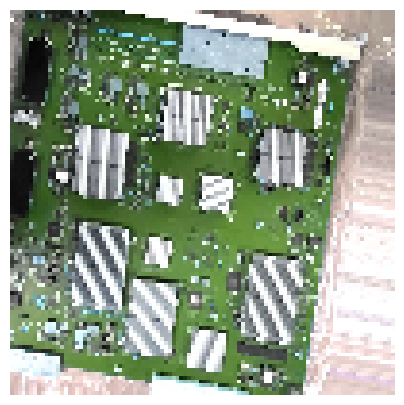

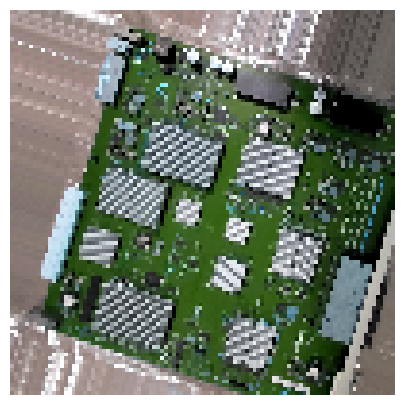

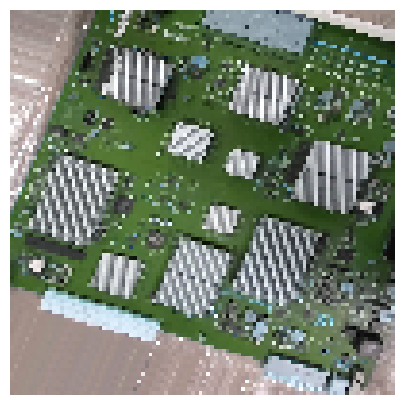

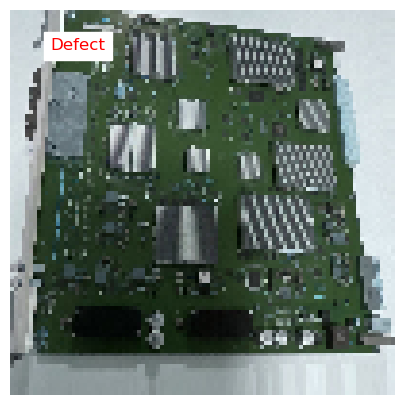

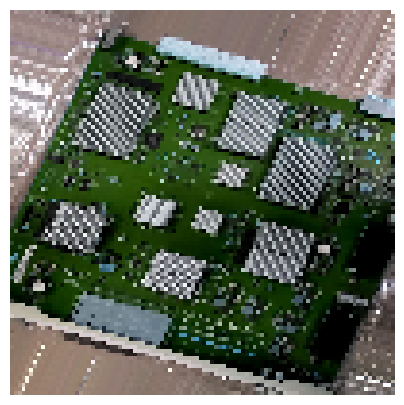

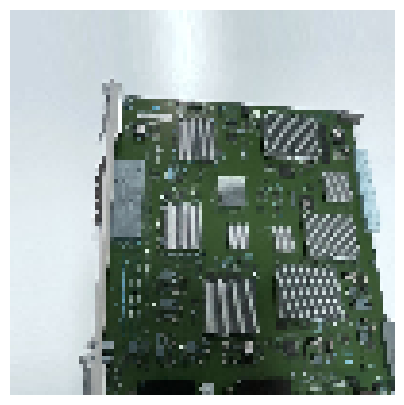

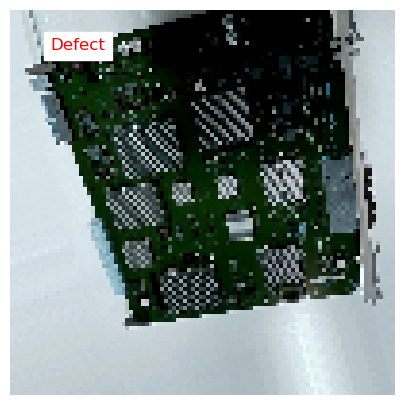

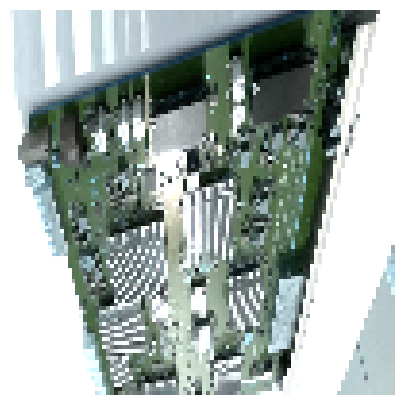

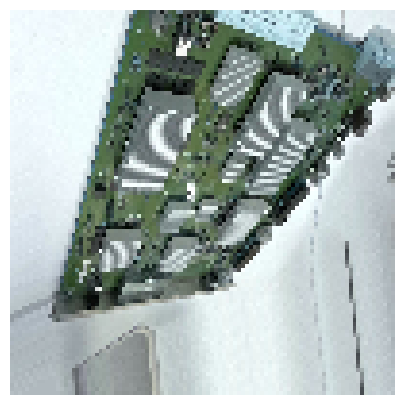

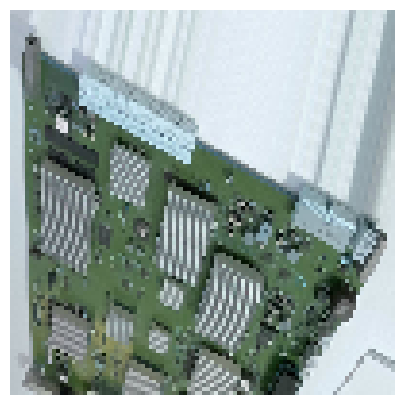

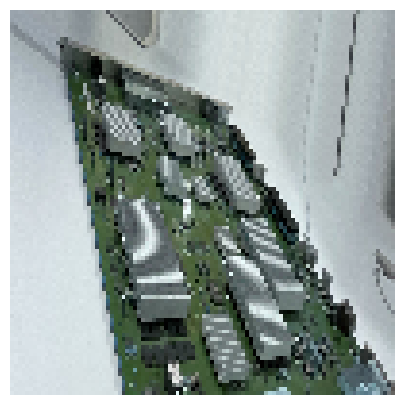

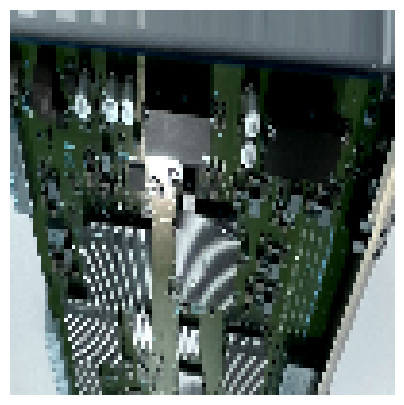

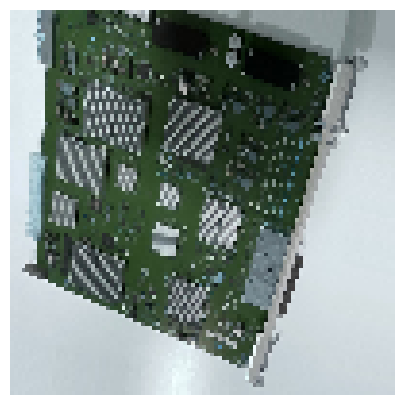

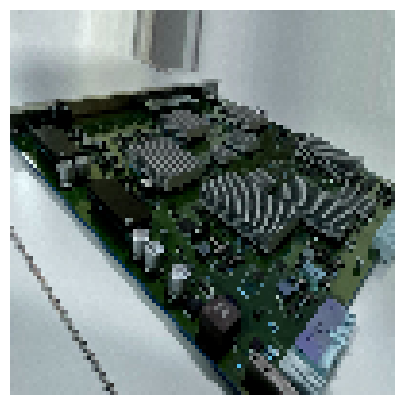

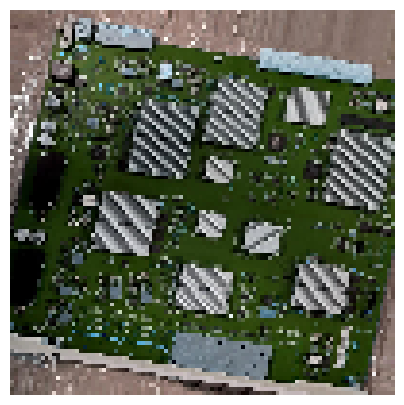

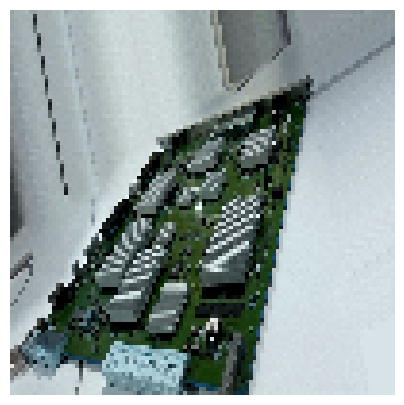

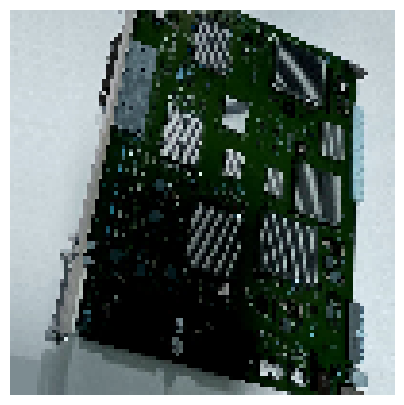

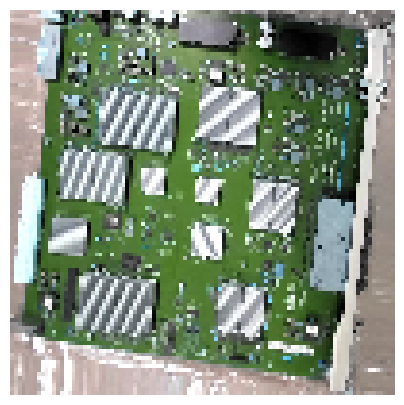

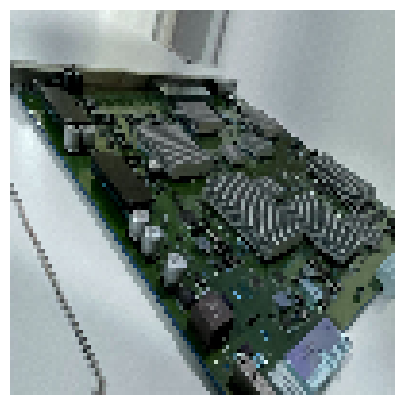

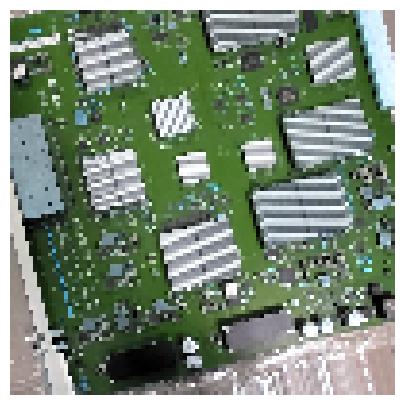

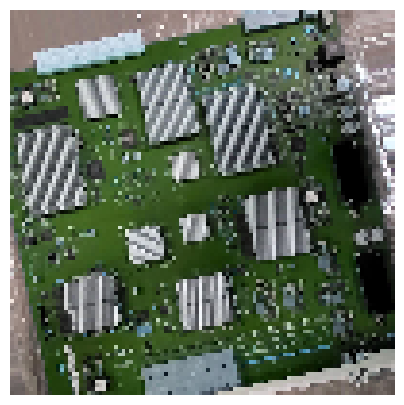

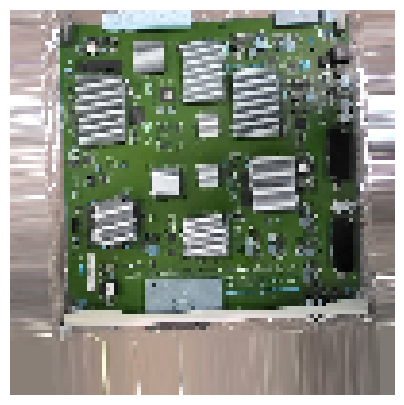

In [10]:
original_test_images = load_corresponding_original_images(output_folder_path, input_folder_path, target_size=(100, 100))

import matplotlib.pyplot as plt

def display_image_with_label(img, is_anomaly):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)  # Assuming img is in the correct format for display
    if is_anomaly:
        plt.text(10, 10, 'Defect', color='red', backgroundcolor='white', fontsize=12)
    plt.axis('off')
    plt.show()

# Example usage within a loop, assuming 'anomalies' is a boolean array
# and 'original_test_images' is your array of images to be displayed.
# Example usage within a loop, assuming 'anomalies' is a boolean array
# and 'original_test_images' is your array of images to be displayed.
for img, is_anomaly in zip(original_test_images, anomalies):
    display_image_with_label(img, is_anomaly)


In [11]:
# Function to calculate accuracy
def calculate_accuracy(model, X_val):
    # Predict reconstruction for validation set
    reconstructed_images = model.predict(X_val)
    # Compute binary cross-entropy loss for each image
    binary_crossentropy = np.mean(np.abs(X_val - reconstructed_images))
    # Calculate accuracy (1 - binary cross-entropy)
    accuracy = 1 - binary_crossentropy
    return accuracy
calculate_accuracy(model,X_val)

4/4 [==============================] - 1s 131ms/step


0.880524754524231

In [12]:
history

In [ ]:
# Load the image you want to test
test_image_path = r'path_to_your_test_image.jpg'  # Provide the path to your test image
test_img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale mode

# Preprocess the test image (resize and normalize)
target_size = (100, 100)  # Specify the target size
test_img_resized = cv2.resize(test_img, target_size)  # Resize the image
test_img_normalized = test_img_resized.astype('float32') / 255.  # Normalize the image

# Reshape the test image for prediction (add channel dimension)
test_img_input = np.expand_dims(test_img_normalized, axis=-1)  # Add a channel dimension at the end

# Use the trained autoencoder model to reconstruct the input image
reconstructed_img = model.predict(np.expand_dims(test_img_input, axis=0))[0]

# Calculate the reconstruction error between the input and reconstructed image
reconstruction_error = np.mean(np.abs(test_img_input - reconstructed_img))

# Determine whether the image is anomalous based on the reconstruction error and a chosen threshold
threshold = 0.1  # Adjust this threshold as needed
is_anomalous = reconstruction_error > threshold

# Display the input and reconstructed images along with the anomaly detection result
plt.figure(figsize=(12, 6))

# Display the input image
plt.subplot(1, 3, 1)
plt.imshow(test_img_normalized, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# Display the reconstructed image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_img.squeeze(), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

# Display the anomaly detection result
plt.subplot(1, 3, 3)
if is_anomalous:
    plt.text(0.5, 0.5, 'Anomalous', color='red', fontsize=14, ha='center')
else:
    plt.text(0.5, 0.5, 'Normal', color='green', fontsize=14, ha='center')
plt.title('Anomaly Detection Result')
plt.axis('off')

plt.show()
